In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from bs4 import BeautifulSoup
import requests
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
class WebScraper:
    @staticmethod
    def get_sp500_symbols():
        """
        Use bs4 to parse HTML and append stock symbols to a list.

        Returns:
        List[str]: List of S&P 500 stock symbols.
        """
        url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        try:
            table_rows = soup.select('table.wikitable tbody tr')[1:]
            return [row.find('td').text.strip().replace('.', '-') for row in table_rows if row.find('td')]
        except AttributeError as e:
            print(f"Error extracting symbols: {str(e)}")
            return []

In [3]:
class DataPreProcessor:
    @staticmethod
    def calculate_rolling_stats(stock_data, window=20):
        """
        Calculate rolling mean and rolling standard deviation of close price.

        Parameters:
        - stock_data (pd.DataFrame): DataFrame containing stock data.
        - window (int): Size of the rolling window (default: 20).

        Returns:
        pd.DataFrame: DataFrame with calculated rolling mean and rolling standard deviation.
        """
        stock_data['RollingMean'] = stock_data['Close'].rolling(window=window).mean()
        stock_data['RollingStd'] = stock_data['Close'].rolling(window=window).std()
        return stock_data[['Symbol', 'Close', 'RollingMean', 'RollingStd']].dropna()

    @staticmethod
    def calculate_differenced_rolling_stats(stock_data, window=20):
        """
        Calculate rolling mean and rolling standard deviation of differenced close price.

        Parameters:
        - stock_data (pd.DataFrame): DataFrame containing stock data.
        - window (int): Size of the rolling window (default: 20).

        Returns:
        pd.DataFrame: DataFrame with calculated rolling mean and rolling standard deviation of differenced close price.
        """
        stock_data['Close (Diff)'] = stock_data['Close'].diff(periods=1)
        stock_data['RollingMean (Diff)'] = stock_data['Close (Diff)'].rolling(window=window).mean()
        stock_data['RollingStd (Diff)'] = stock_data['Close (Diff)'].rolling(window=window).std()
        return stock_data[['Symbol', 'Close (Diff)', 'RollingMean (Diff)', 'RollingStd (Diff)']].dropna()

    @staticmethod
    def plot_data(stock_data, column_1, column_2, column_3, title):
        """
        Plot historical prices and rolling stats after differencing.

        Parameters:
        - stock_data (pd.DataFrame): DataFrame containing stock data.
        - column_1 (str): Name of the original column to plot.
        - column_2 (str): Name of the rolling mean column to plot.
        - column_3 (str): Name of the rolling standard deviation column to plot.
        - title (str): Title of the plot.
        """
        if stock_data is not None:
            plt.figure(figsize=(18, 10))
            plt.plot(stock_data.index, stock_data[column_1], label='Original')
            plt.plot(stock_data.index, stock_data[column_2], label='Rolling Mean')
            plt.plot(stock_data.index, stock_data[column_3], label='Rolling Std')
            plt.title(title)
            plt.legend()
            plt.show()
        else:
            raise Exception("Error: No data available")

    @staticmethod
    def calculate_adf_results(stock_data, column):
        """
        Perform Augmented Dickey-Fuller test on original/differenced data.
        Ho - Data is not stationary; p-value is greater than 0.05
        Ha - Data is stationary: p-value is less than 0.05

        Parameters:
        - stock_data (pd.DataFrame): DataFrame containing stock data.
        - column (str): Name of the column to perform the ADF test on.

        Returns:
        Tuple: ADF test results including ADF statistic, p-value, and critical values.
        """
        if stock_data is not None:
            adf_test_result = adfuller(stock_data[column])
            print(
                f'ADF Statistic: {adf_test_result[0]}\n'
                f'p-value: {adf_test_result[1]}\n'
                f'Data is {"stationary. Sufficient evidence to reject null." if adf_test_result[1] < 0.05 else "not stationary. Insufficient evidence to reject null"}\n'
                f'Critical Values:\n' + '\n'.join([f'{key:>5}: {value:.3f}' for key, value in adf_test_result[4].items()]),
                '\n'
            )
            return adf_test_result
        else:
            raise Exception("Error: No data available")

In [4]:
class StockData:
    def __init__(self, stock_symbol, start_date='2010-01-01', end_date='2020-12-31', differencing_limit=2):
        """
        Initialize StockData object.

        Parameters:
        - stock_symbol (str): The stock symbol to retrieve data for.
        - start_date (str): The start date for historical data (default: '2010-01-01').
        - end_date (str): The end date for historical data (default: '2023-12-31').
        - differencing_limit (int): The maximum number of differencing iterations (default: 2).
        """
        self.stock_symbol = stock_symbol
        self.start_date = start_date
        self.end_date = end_date
        self.stock_data = None
        self.differencing_limit = differencing_limit
        self.train_data = None
        self.test_data = None
        self.model = None
        self.fit_model = None
        self.predictions = None

    def get_stock_data(self):
        """
        Retrieve historical/time-series data using yfinance.

        Returns:
        pd.DataFrame: DataFrame containing stock data.
        """
        try:
            yf_ticker = yf.Ticker(self.stock_symbol)
            df_historical_data = pd.DataFrame(yf_ticker.history(start=self.start_date, end=self.end_date, interval='1d', auto_adjust=True))
            df_historical_data.index = df_historical_data.index.tz_localize(None)
            df_historical_data = df_historical_data.asfreq('B', method='ffill')
            df_historical_data['Symbol'] = self.stock_symbol
            df_historical_data = df_historical_data[['Symbol'] + df_historical_data.columns[:-1].tolist()]
            if len(df_historical_data) == 0:
                raise Exception('No data found')
            self.stock_data = df_historical_data
        except Exception as e:
            if str(e) == 'No data found':
                raise Exception(f'Error: No data received for {self.stock_symbol}: {e}')
            else:
                raise Exception(f'Error getting data for {self.stock_symbol}: {e}')
        return df_historical_data

    def preprocess_data(self):
        """
        Call DataProcessor class to process and analyze data.
        Processed data and graphs will be used to determine ARIMA(p, d, q) parameters.
        differencing_iter - give d parameter value.

        Returns:
        pd.DataFrame: Processed stock data.
        """
        if self.stock_data is not None:
            self.stock_data = DataPreProcessor.calculate_rolling_stats(self.stock_data)
            print('DISPLAYING ORIGINAL DATA...')
            DataPreProcessor.plot_data(self.stock_data, 'Close', 'RollingMean', 'RollingStd', 'Closing Prices - Original')
            print('ADF TEST - ORIGINAL:')
            adf_result = DataPreProcessor.calculate_adf_results(self.stock_data, 'Close')
            differencing_iter = 0
            while adf_result[1] > 0.05 and differencing_iter < self.differencing_limit:
                differencing_iter += 1
                stock_data_diff = DataPreProcessor.calculate_differenced_rolling_stats(self.stock_data)
                print('DISPLAYING DIFFERENCED DATA...')
                DataPreProcessor.plot_data(stock_data_diff, 'Close (Diff)', 'RollingMean (Diff)', 'RollingStd (Diff)', f'Closing Prices - Differenced (d={differencing_iter})')
                print(f'ADF TEST - DIFFERENCED (d={differencing_iter}):')
                adf_result = DataPreProcessor.calculate_adf_results(stock_data_diff, 'Close (Diff)')
            return self.stock_data
        else:
            raise Exception("Error: No data available")

    def split_data(self):
        """
        Split data into training and testing sets.

        Returns:
        Tuple[pd.Series, pd.Series]: Training and testing datasets.
        """
        if self.stock_data is not None:
            self.train_data = self.stock_data['Close'].loc['2010-01-01':'2019-12-31']
            self.test_data = self.stock_data['Close'].loc['2020-01-01':]
            return self.train_data, self.test_data
        else:
            raise Exception("Error: No data available")

    def fit_arima_model(self, p, d, q):
        """
        Build and fit ARIMA model.

        Parameters:
        - p (int): AR order.
        - d (int): Differencing order.
        - q (int): MA order.

        Returns:
        statsmodels.tsa.arima.model.ARIMAResultsWrapper: Fitted ARIMA model.
        """
        if self.train_data is not None:
            self.model = ARIMA(self.train_data, order=(p, d, q))
            print(f'FITTING MODEL ARIMA{p, d, q}...')
            self.fit_model = self.model.fit()
            print(self.fit_model.summary())
            return self.fit_model

    def plot_residuals_acf_pacf(self):
        """
        Plot ACF and PACF of model residuals.
        Graphs will be used to obtain p and q parameter values.

        Raises:
        Exception: If model has not been fitted
        """
        if self.fit_model is not None:
            residuals = self.fit_model.resid
            print('DISPLAYING RESIDUALS DATA...')
            fig, (ax1, ax2) = plt.subplots(2, figsize=(18,10))
            acf = plot_acf(residuals, lags=90, ax=ax1)
            ax1.set_title('ACF Long-Term')
            acf = plot_acf(residuals, lags=30, ax=ax2)
            ax2.set_title('ACF Short-Term')
            plt.show()

            fig, (ax1, ax2) = plt.subplots(2, figsize=(18,10))
            pacf = plot_pacf(residuals, lags=90, ax=ax1)
            ax1.set_title('PACF Long-Term')
            pacf = plot_pacf(residuals, lags=30, ax=ax2)
            ax2.set_title('PACF Short-Term')
            plt.show()
        else:
            raise Exception("Error: Model not fitted")
    
    def fit_rolling_model(self, p, d, q, window):
        """
        Fit an ARIMA model with a rolling window approach.

        Parameters:
        - p (int): AR order.
        - d (int): Differencing order.
        - q (int): MA order.
        - window (int): Size of the rolling window.

        Returns:
        List[float]: Predicted values.
        """
        if self.train_data is not None or self.test_data is not None:
            history = [x for x in self.train_data]
            self.predictions = []
            for t in range(0, len(self.test_data), window):
                model = ARIMA(history, order=(p, d, q))
                model_fit = model.fit()
                output = model_fit.forecast(steps=window)
                self.predictions.extend(output)
                if t+window < len(self.test_data):
                    history.extend(self.test_data[t:t+window])
        return self.predictions

    def plot_rolling_model(self):
        """
        Plot the results of the rolling ARIMA model.

        Raises:
        Exception: If predictions have not been made.
        """
        if self.predictions is not None:
            plt.figure(figsize=(18, 10))
            plt.plot(self.train_data.index, self.train_data, label='train')
            plt.plot(self.test_data.index, self.test_data, label='test')
            plt.plot(self.test_data.index, self.predictions[:len(self.test_data)], label='pred')
            plt.legend()
            plt.title('Predicted vs. Actual')
            plt.show()
        else:
            raise Exception("Error: Predicitons have not been made")
    
    def evaluate_model_performance(self):
        """
        Evaluate the performance of the ARIMA model using common regression metrics.

        Raises:
        Exception: If predictions have not been made.
        """
        if self.predictions is not None:
            mse = mean_squared_error(self.test_data, self.predictions[:len(self.test_data)])
            rmse = mean_squared_error(self.test_data, self.predictions[:len(self.test_data)], squared=False)
            mae = mean_absolute_error(self.test_data, self.predictions[:len(self.test_data)])
            r2 = r2_score(self.test_data, self.predictions[:len(self.test_data)])

            print(f'Mean Squared Error (MSE): {mse:.4f}')
            print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
            print(f'Mean Absolute Error (MAE): {mae:.4f}')
            print(f'R-squared (R2): {r2:.4f}')
        else:
            raise Exception("Error: Predictions have not been made")

Selected Stock Symbol: AAPL 

DISPLAYING ORIGINAL DATA...


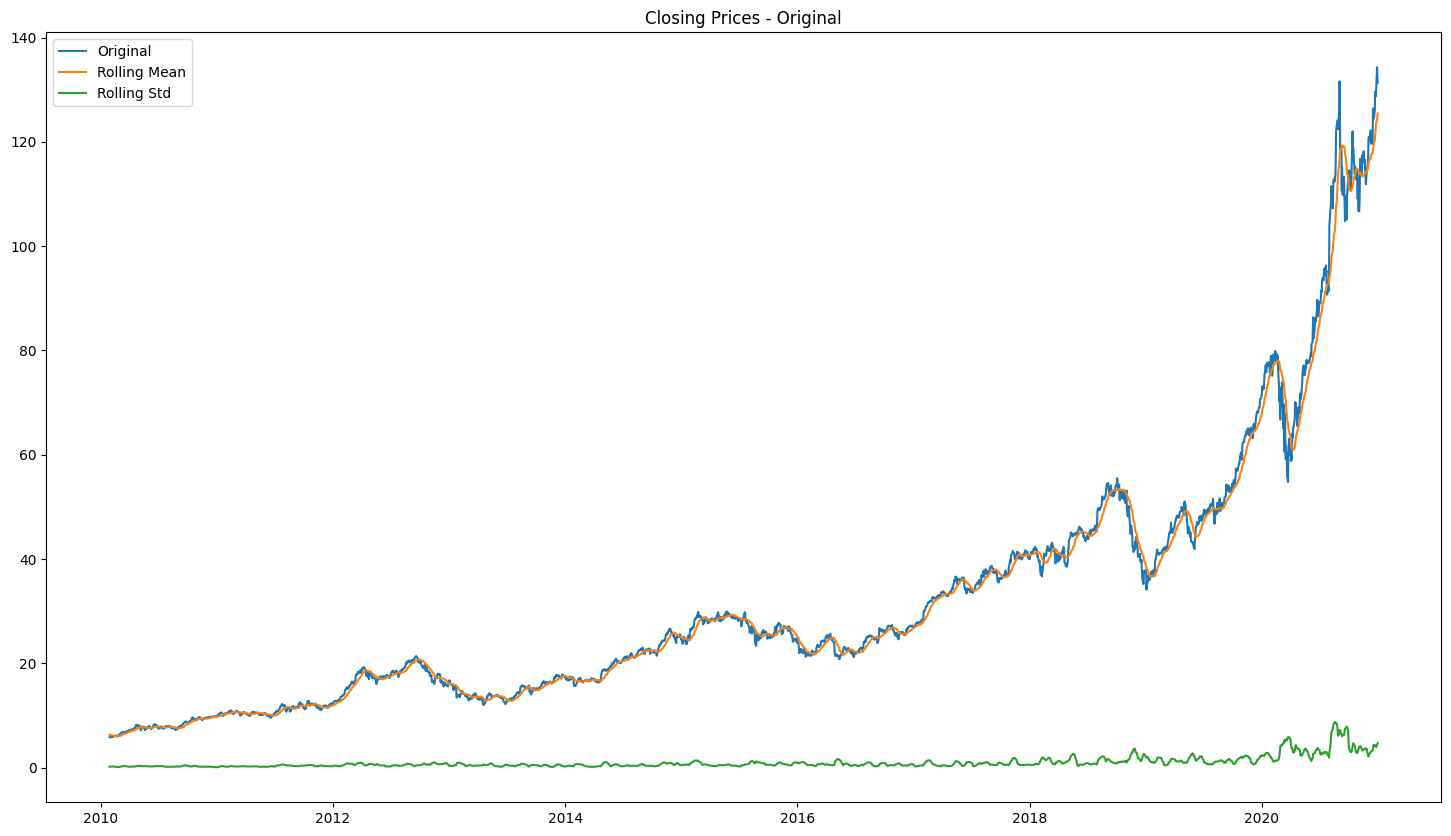

ADF TEST - ORIGINAL:
ADF Statistic: 3.612546264331382
p-value: 1.0
Data is not stationary. Insufficient evidence to reject null
Critical Values:
   1%: -3.433
   5%: -2.863
  10%: -2.567 

DISPLAYING DIFFERENCED DATA...


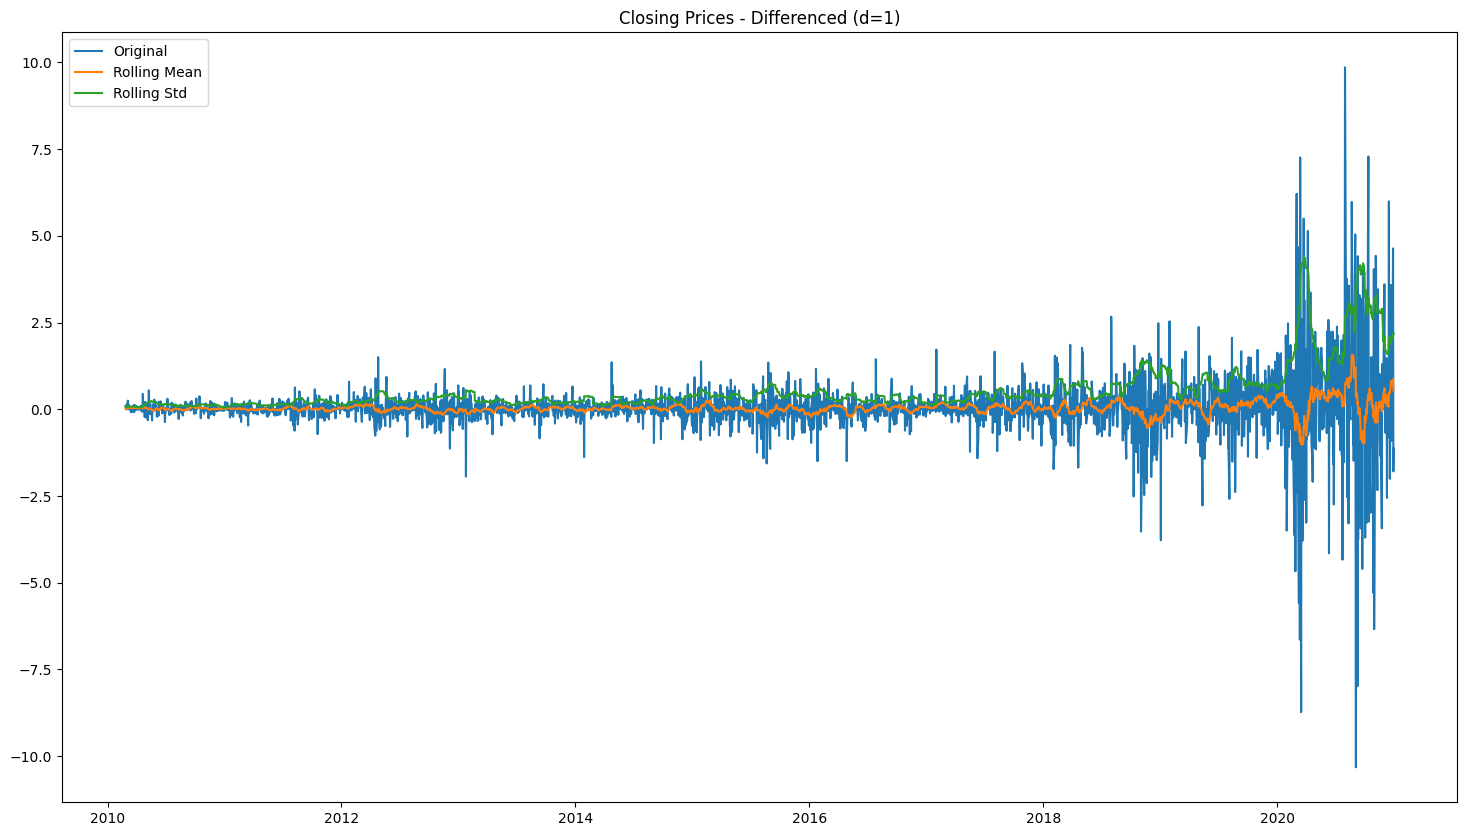

ADF TEST - DIFFERENCED (d=1):
ADF Statistic: -9.8561107824961
p-value: 4.355164423688105e-17
Data is stationary. Sufficient evidence to reject null.
Critical Values:
   1%: -3.433
   5%: -2.863
  10%: -2.567 

FITTING MODEL ARIMA(0, 0, 0)...
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2588
Model:                          ARIMA   Log Likelihood              -10496.771
Date:                Thu, 14 Dec 2023   AIC                          20997.542
Time:                        08:52:17   BIC                          21009.259
Sample:                    01-29-2010   HQIC                         21001.788
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

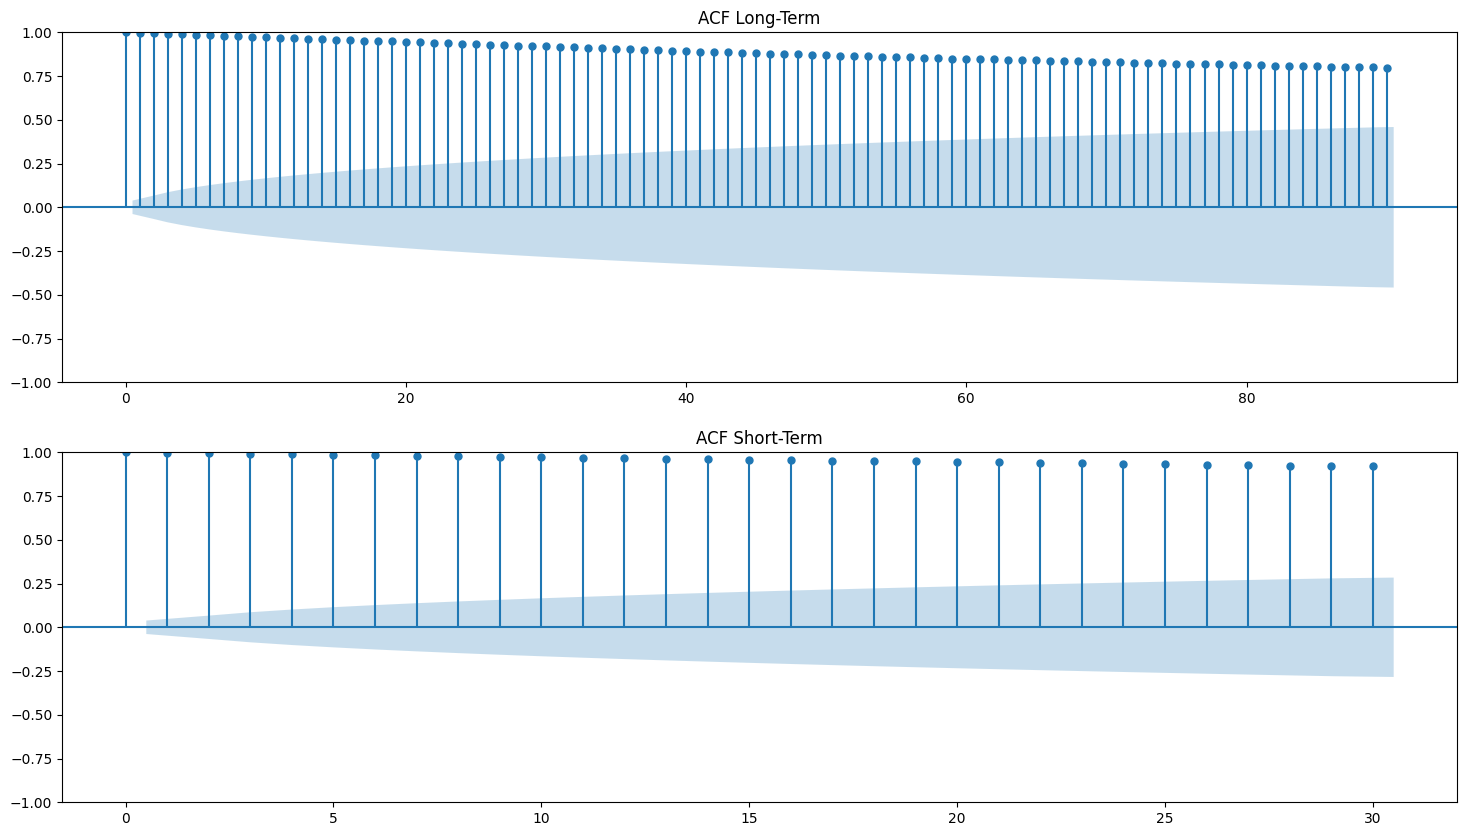

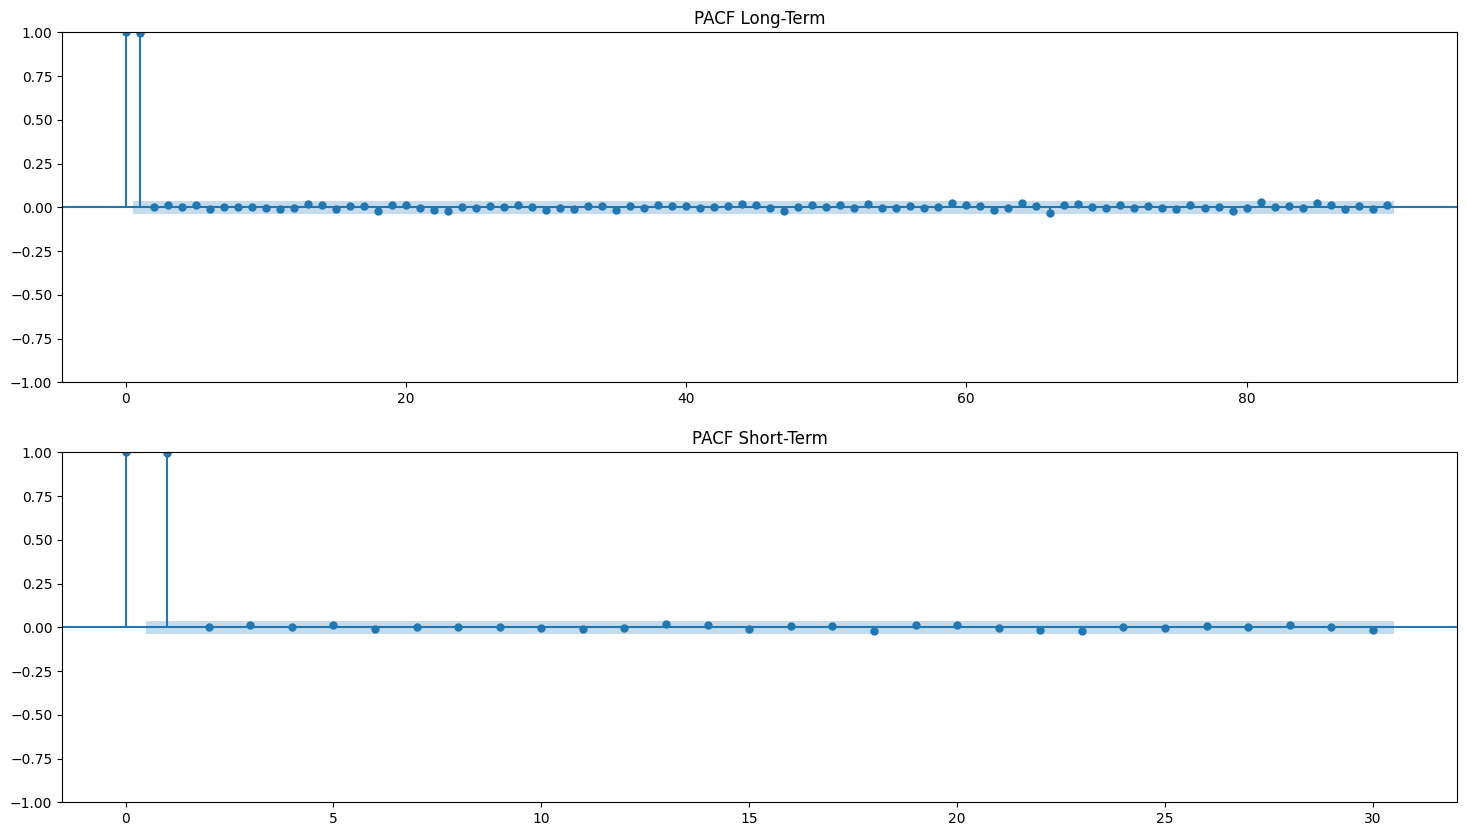

FITTING MODEL ARIMA(1, 1, 1)...
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1572.109
Date:                Thu, 14 Dec 2023   AIC                           3150.218
Time:                        08:52:18   BIC                           3167.793
Sample:                    01-29-2010   HQIC                          3156.588
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9033      0.045    -20.047      0.000      -0.992      -0.815
ma.L1          0.9260      0.041     22.743      0.000       0.846       1.006
sigma2         0.197

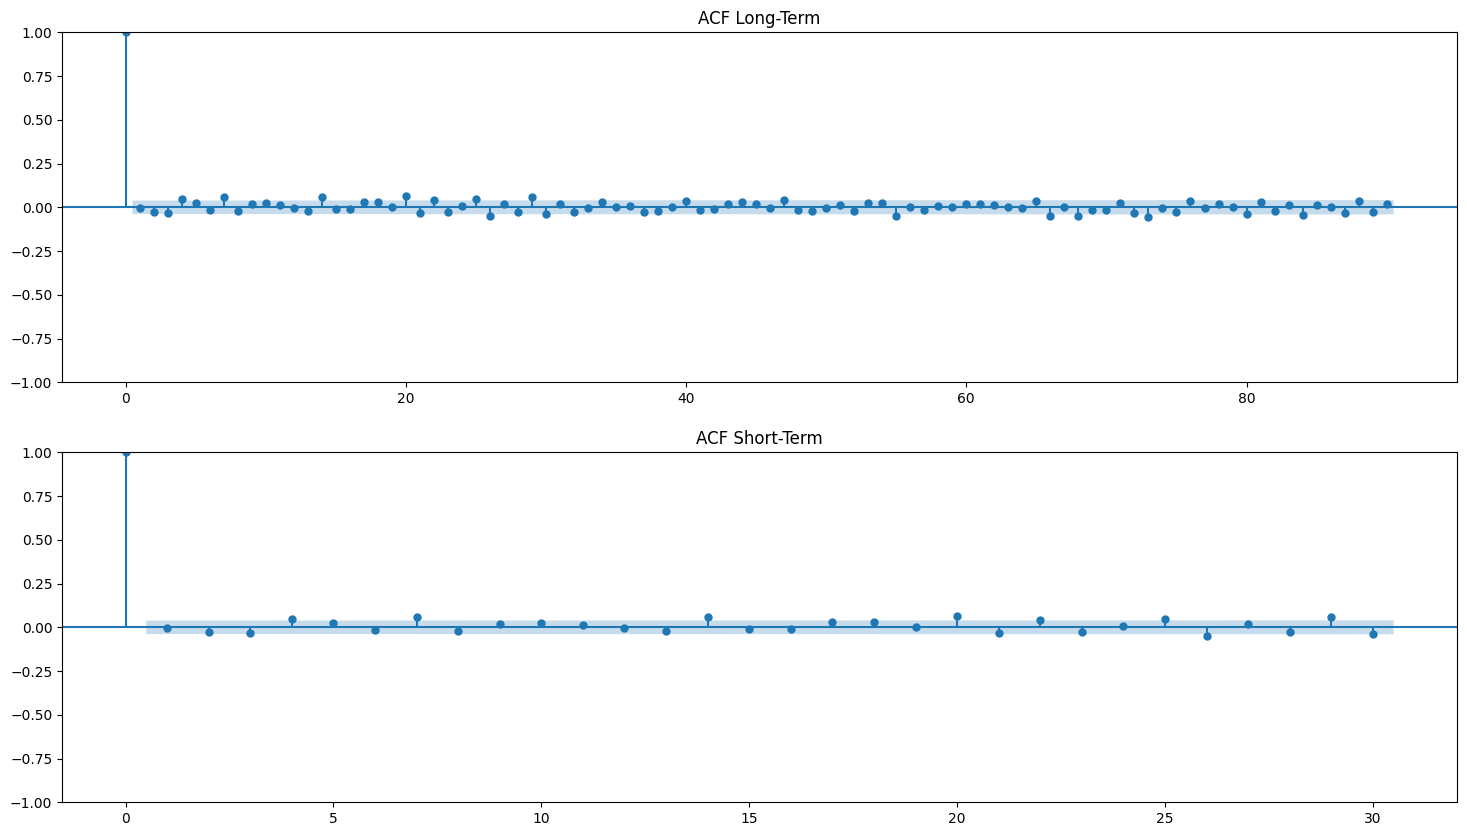

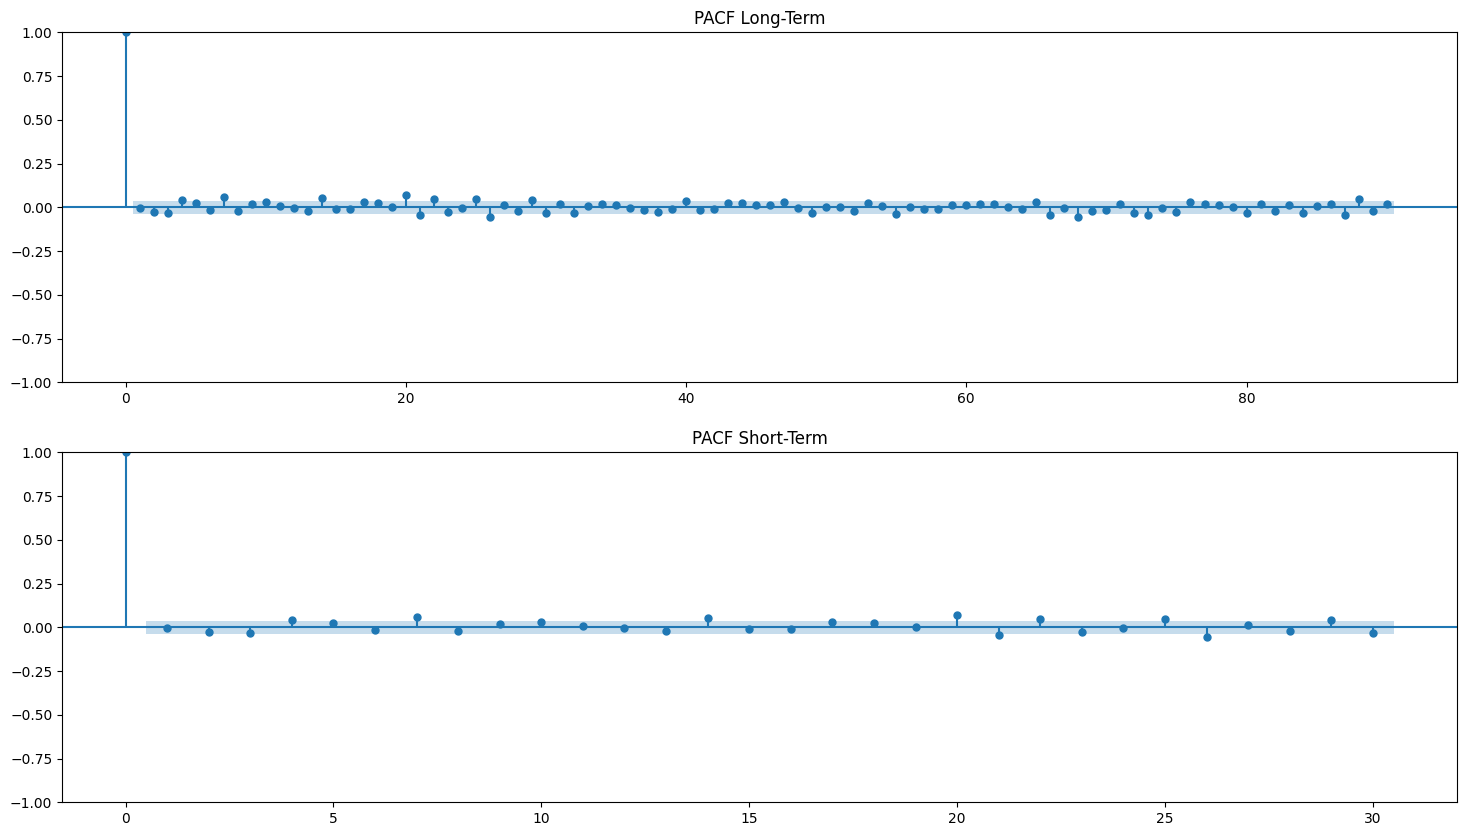

c:\Users\nickd\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\nickd\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


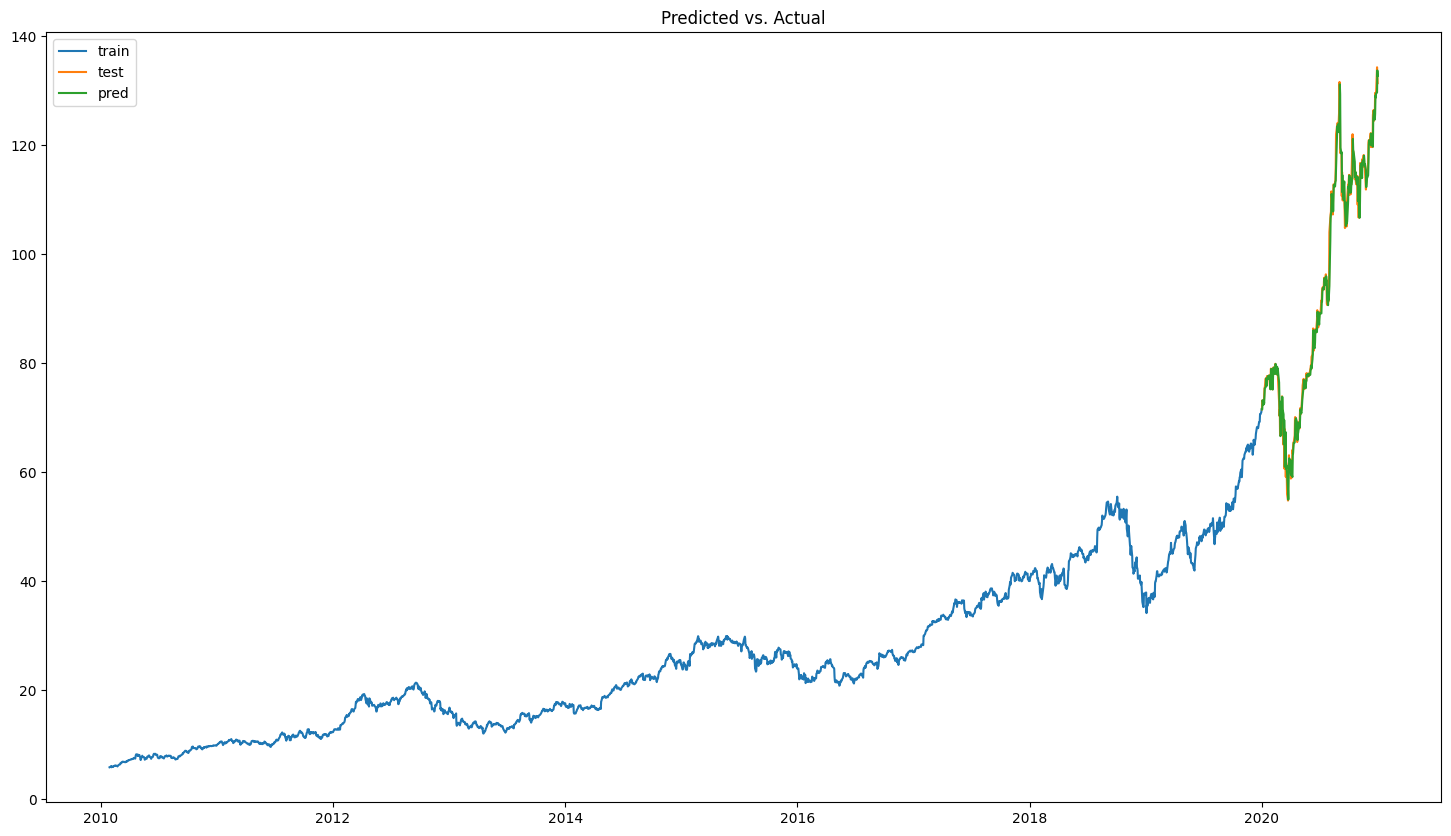

Mean Squared Error (MSE): 6.2533
Root Mean Squared Error (RMSE): 2.5007
Mean Absolute Error (MAE): 1.7588
R-squared (R2): 0.9864


In [9]:
if __name__ == "__main__":
    symbols = WebScraper.get_sp500_symbols()
    selected_symbol = 'AAPL' if 'AAPL' in symbols else None
    if selected_symbol:
        print(f"Selected Stock Symbol: {selected_symbol} \n")
        historical_data = StockData(selected_symbol)
        try:
            stock_data = historical_data.get_stock_data()
            differenced_stock_data = historical_data.preprocess_data()
            train_data, test_data = historical_data.split_data()
            
            # use residuals to determine AR(p) and MA(q)
            # Sudden decay at lag(1) in PACF indicative of AR(1)
            # Slow decay of correlation values in ACF indicative of MA(1)
            p, d, q = 0, 0, 0
            differenced_model = historical_data.fit_arima_model(0, 0, 0)
            historical_data.plot_residuals_acf_pacf()       

            p, d, q = 1, 1, 1  
            window = 1
            bestfit_model = historical_data.fit_arima_model(p, d, q)
            historical_data.plot_residuals_acf_pacf()
            
            rolling_model_1day = historical_data.fit_rolling_model(p, d, q, window)
            historical_data.plot_rolling_model()
            historical_data.evaluate_model_performance()

            # rolling_model_10day = historical_data.fit_rolling_model(p, d, q, 10)
            # historical_data.plot_rolling_model()
            # historical_data.evaluate_model_performance()

            # rolling_model_20day = historical_data.fit_rolling_model(p, d, q, 20)
            # historical_data.plot_rolling_model()
            # historical_data.evaluate_model_performance()

        except Exception as e:
            print(f"Error fetching, processing, or modeling data: {str(e)}")
    else:
        print("Selected Stock not found in S&P 500 symbols.")